In [2]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2023-03-29 20:00:40--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819904 (1.7M) [text/plain]
Saving to: 'time_series_covid19_confirmed_global.csv'

     0K .......... .......... .......... .......... ..........  2% 3.07M 1s
    50K .......... .......... .......... .......... ..........  5% 8.87M 0s
   100K .......... .......... .......... .......... ..........  8% 6.42M 0s
   150K .......... .......... .......... .......... .......... 11% 9.22M 0s
   200K .......... .......... .......... .......... .......... 14% 3.82M 0s
   250K .......... .......... .......... .......... .......... 16% 39.6M 0s
   30

In [41]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [42]:
### Data exploration

In [90]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [91]:
#Dropping province, country, latitude, and longitude columns

columns_to_drop = ['Province/State', 'Country/Region', 'Lat', 'Long']

df = df.drop(columns_to_drop, axis = 1, inplace = False)

In [92]:
df.head(5)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [93]:
# Check Missing Values
df.isnull().sum().sum()

0

In [94]:
df = df.iloc[:, 50:]

In [95]:
df

,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,11,11,14,20,25,26,26,26,24,24,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,23,33,38,42,51,55,59,64,70,76,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,24,26,37,48,54,60,74,87,90,139,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,1,1,1,1,2,39,39,53,75,88,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,1,2,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,30,31,35,38,38,39,41,44,47,48,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,0,0,0,0,0,0,2,2,2,2,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [99]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()

2023-03-05    676024901
2023-03-06    676082941
2023-03-07    676213378
2023-03-08    676392824
2023-03-09    676570149
dtype: int64

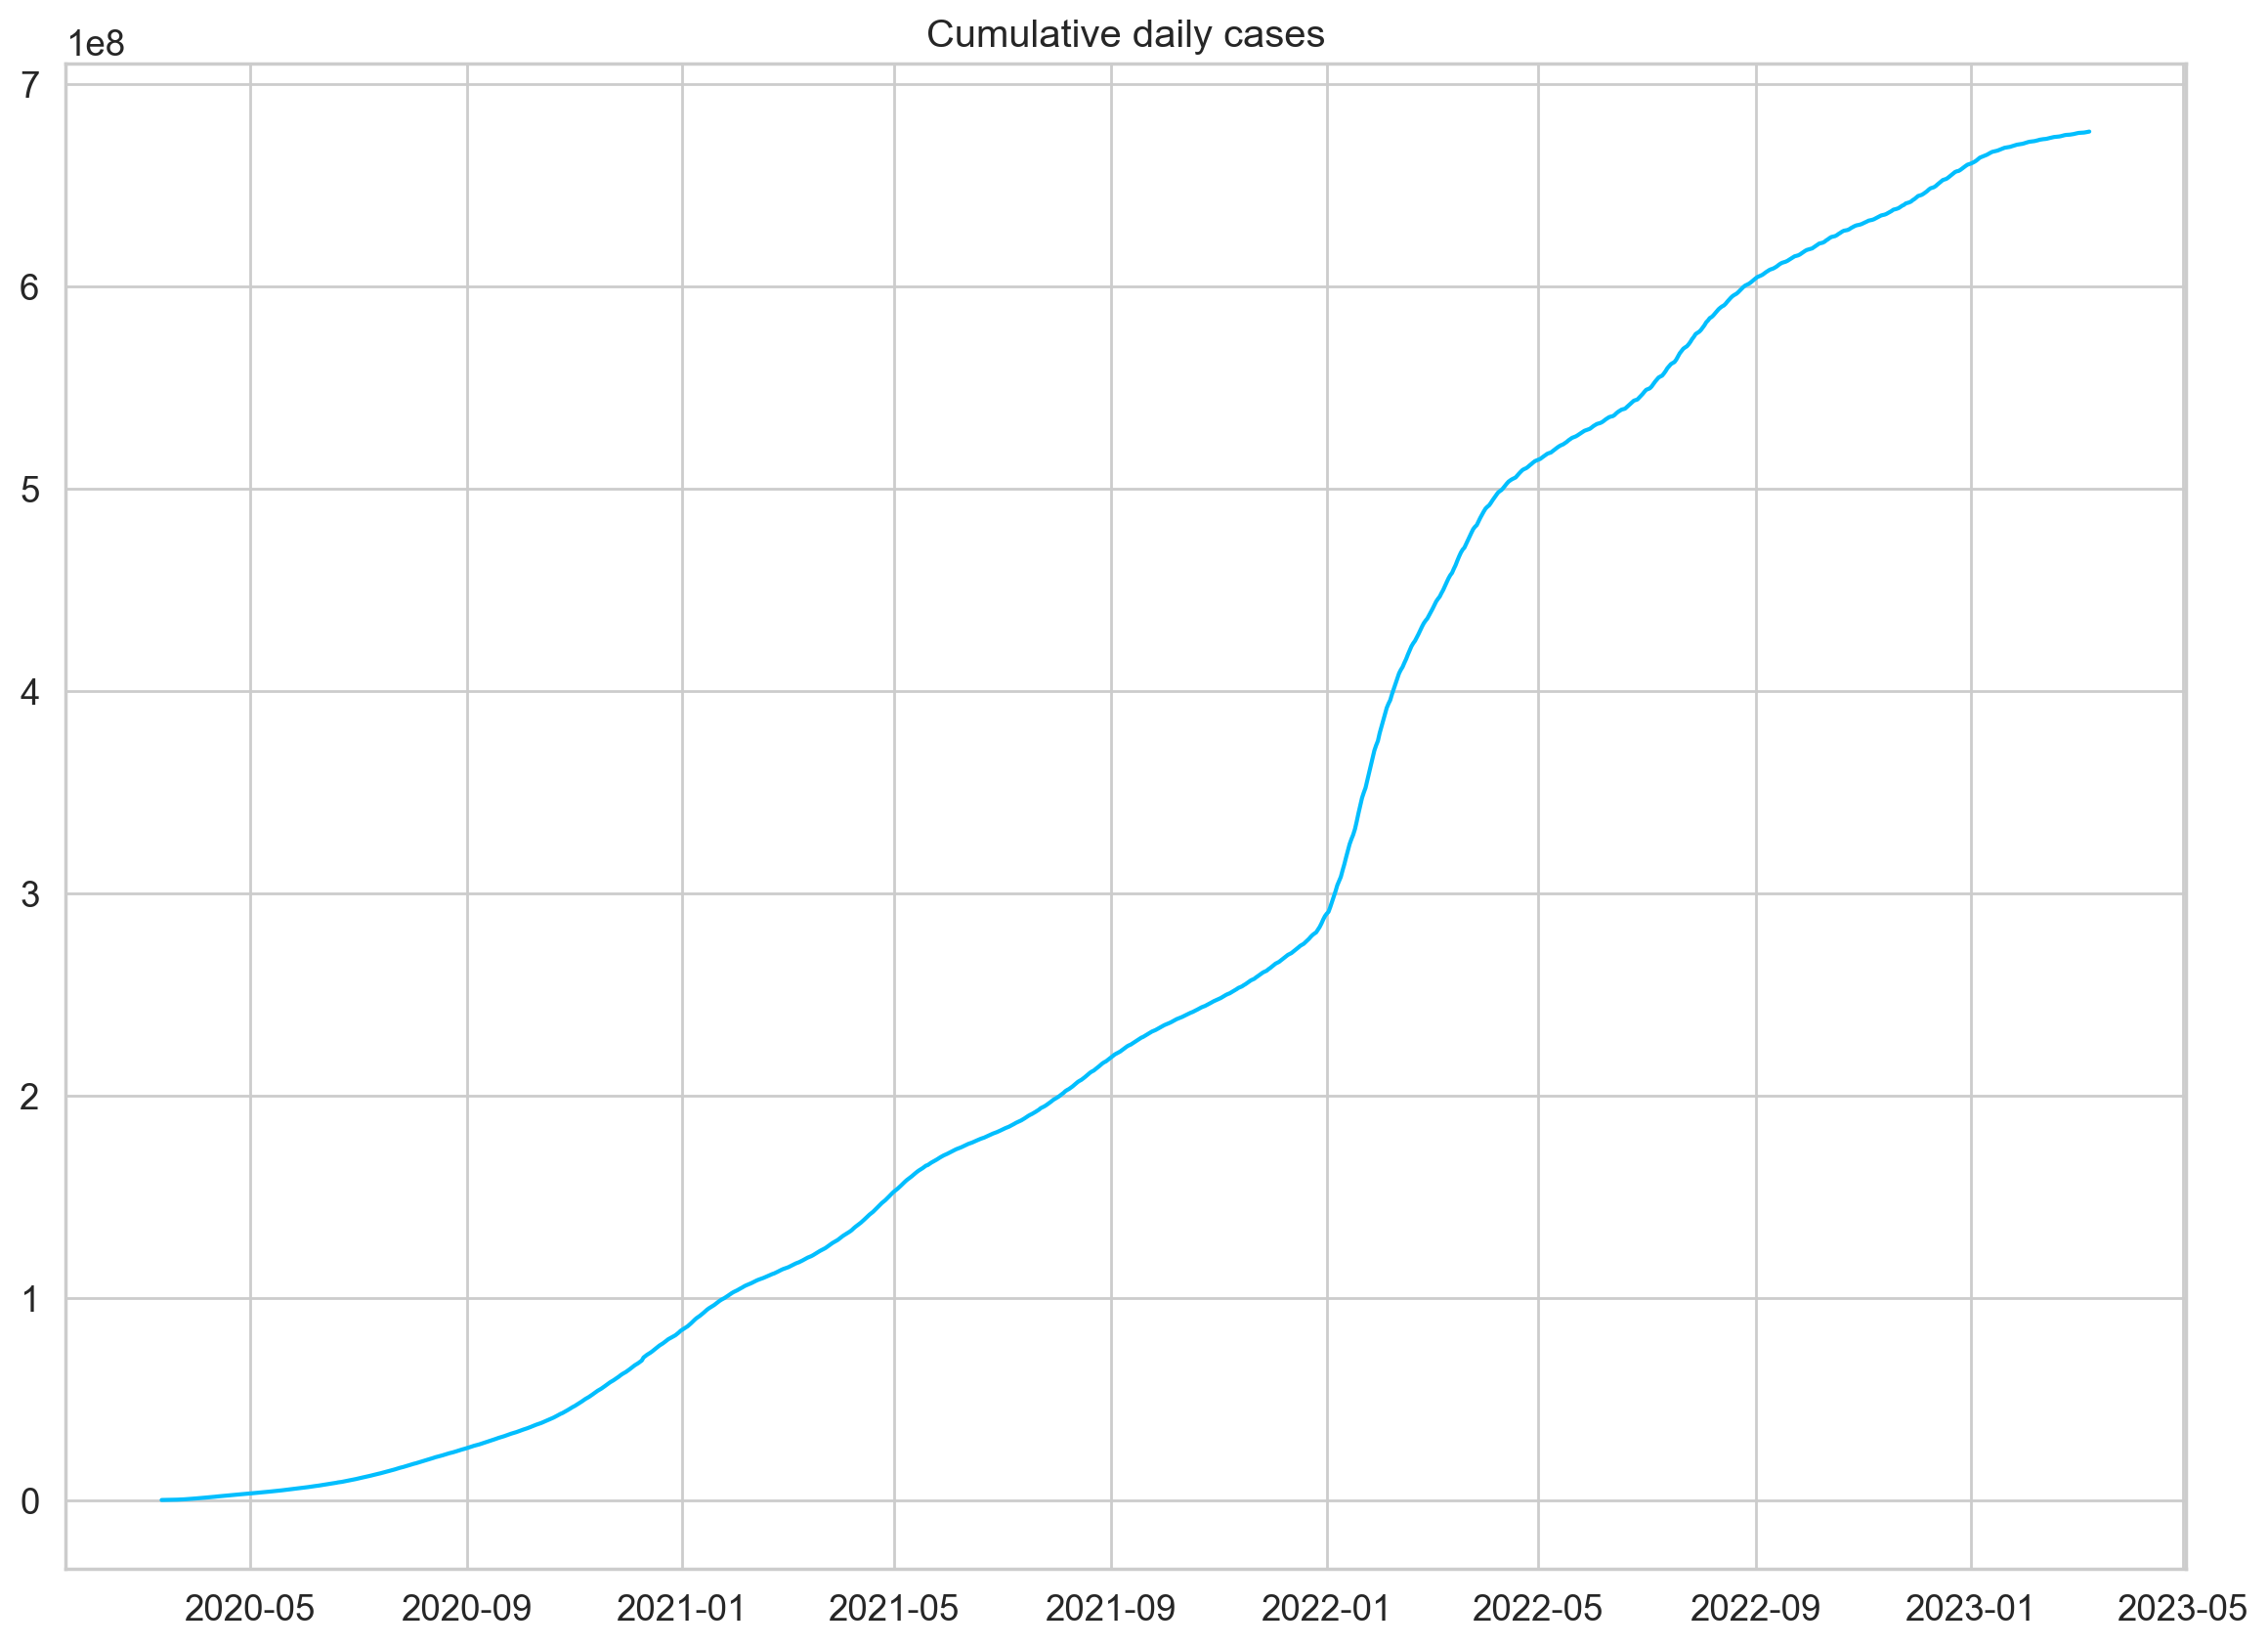

In [100]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [101]:
#subtracting the current value from the previous

daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-03-12    133283
2020-03-13     13194
2020-03-14     10888
2020-03-15     11233
2020-03-16     14567
dtype: int64

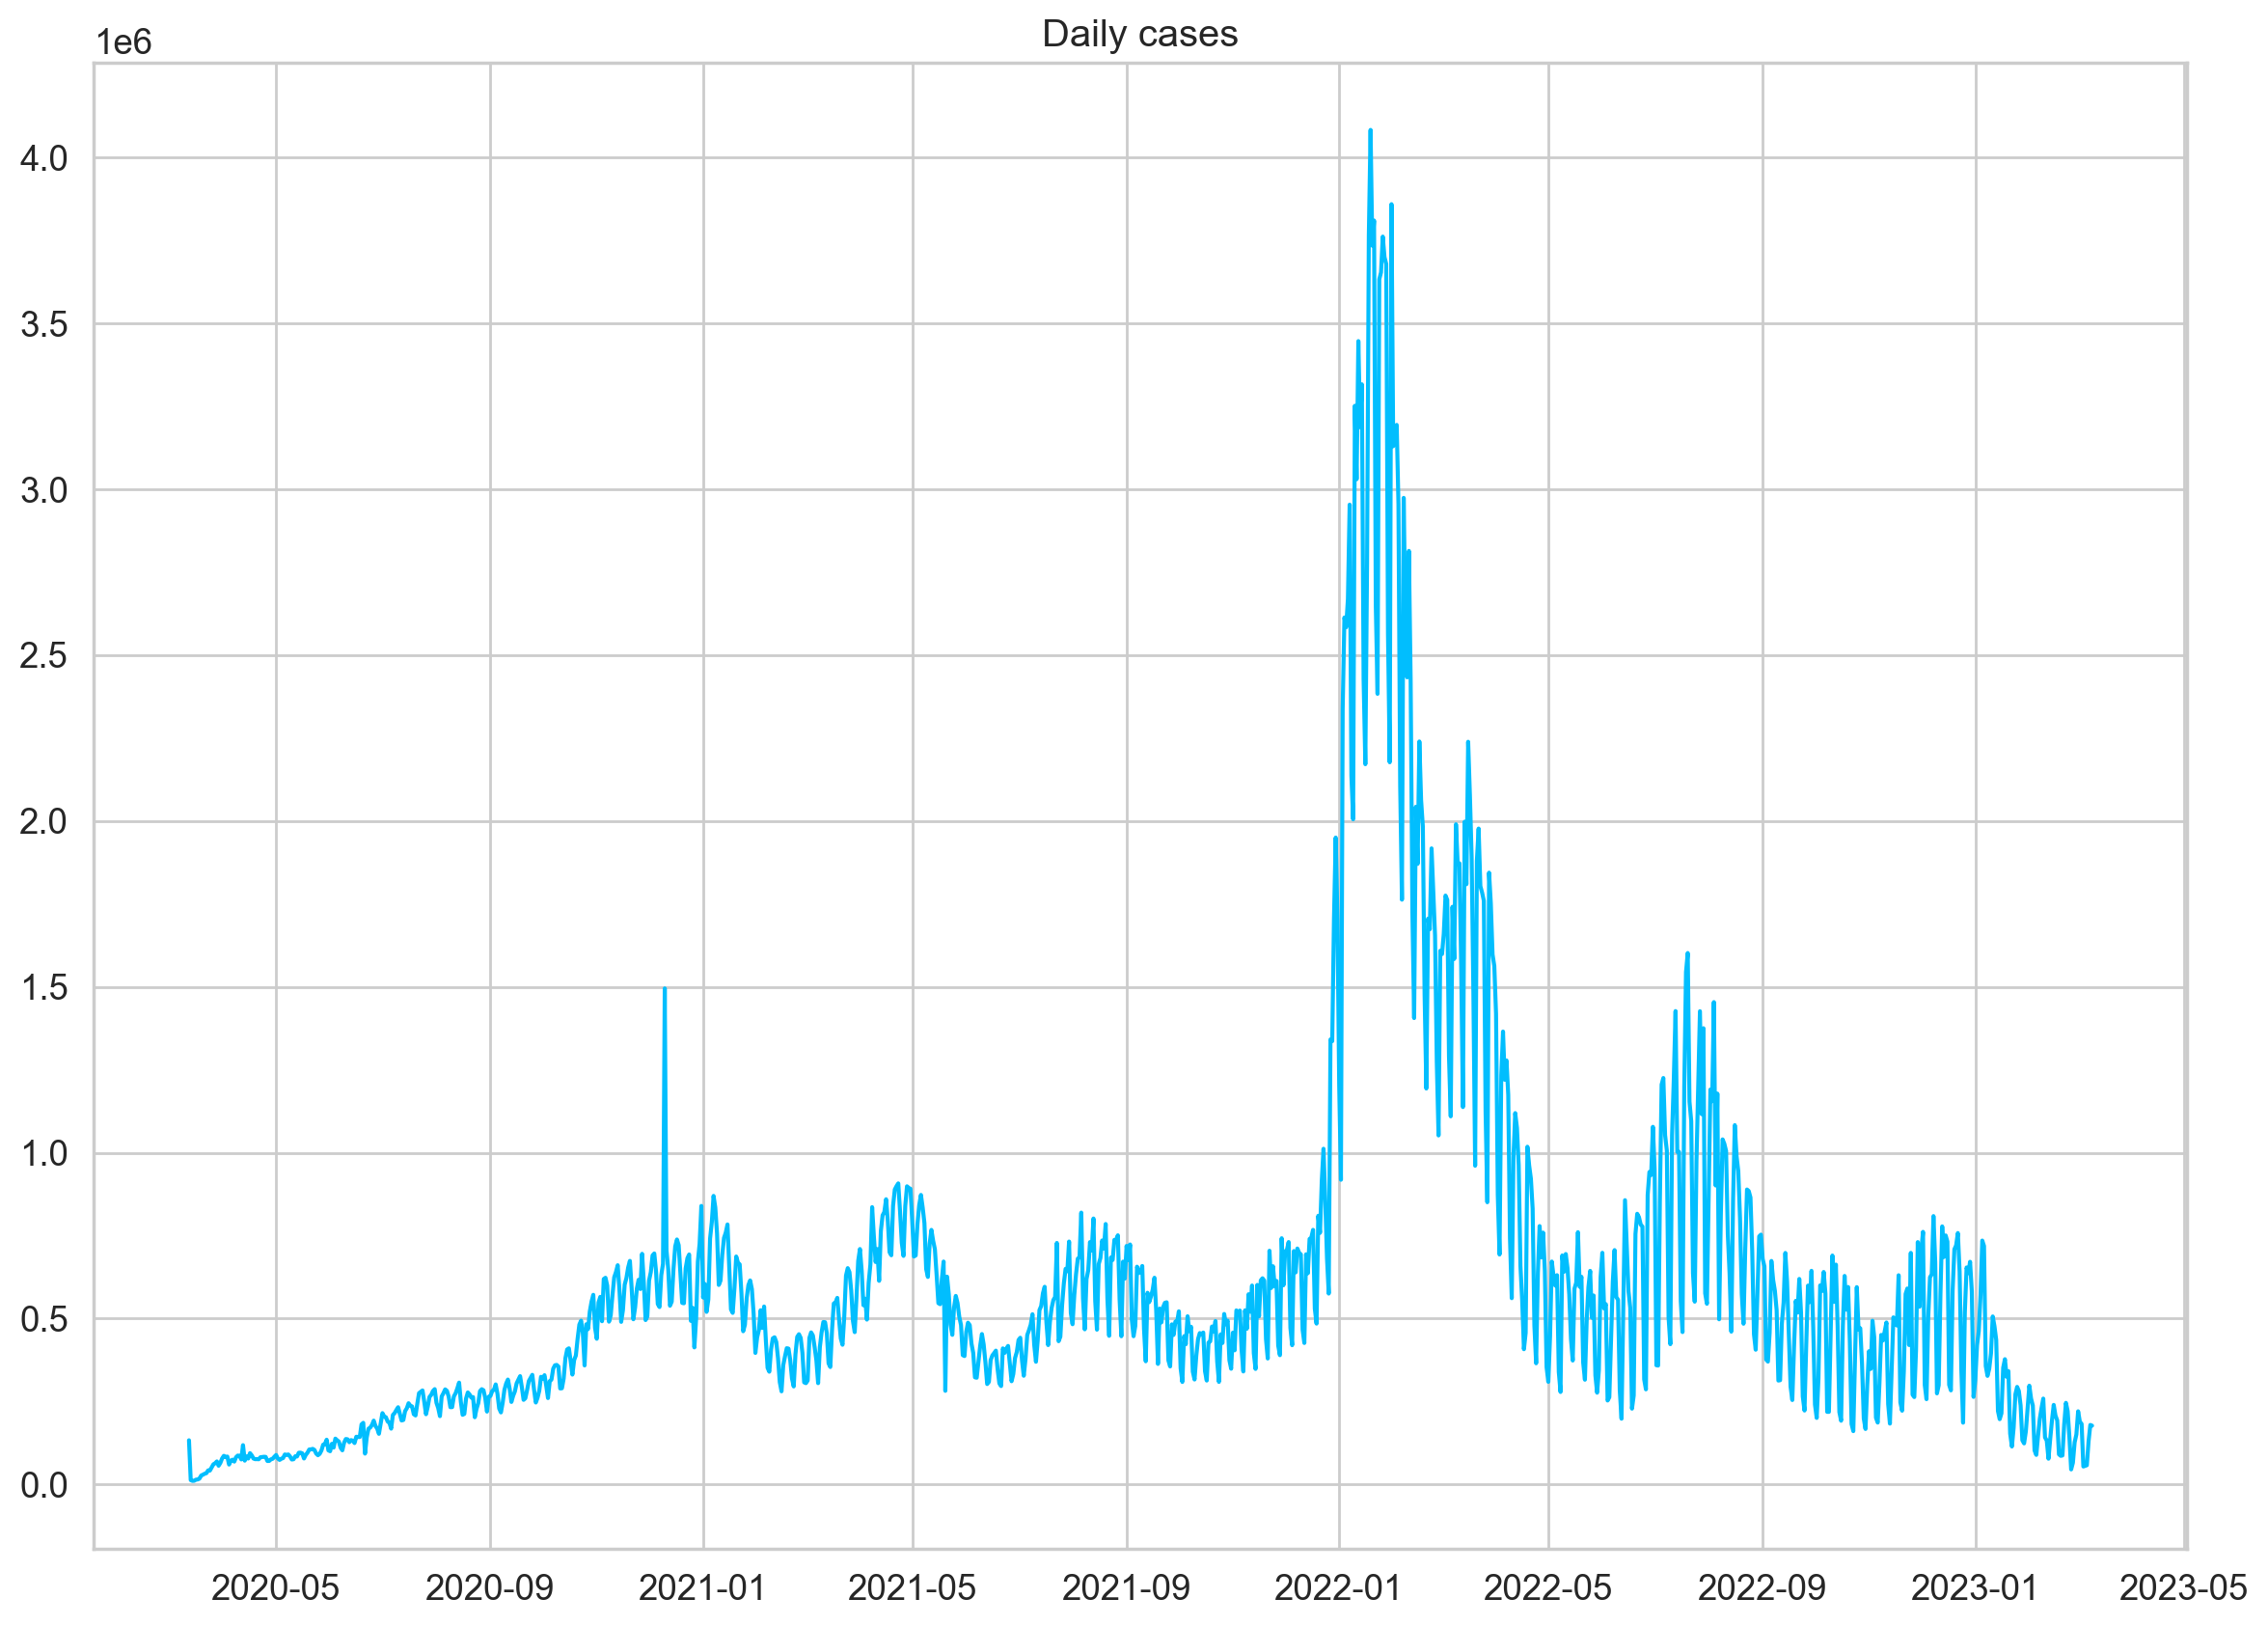

In [102]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [103]:
daily_cases.shape

(1093,)

In [ ]:
###Preprocessing

In [104]:
#Split dataset into training and test

test_data_size = 109

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(984,)

In [106]:
daily_cases[:-test_data_size]

2020-03-12    133283
2020-03-13     13194
2020-03-14     10888
2020-03-15     11233
2020-03-16     14567
               ...  
2022-11-16    486316
2022-11-17    479349
2022-11-18    630724
2022-11-19    247355
2022-11-20    222431
Length: 984, dtype: int64

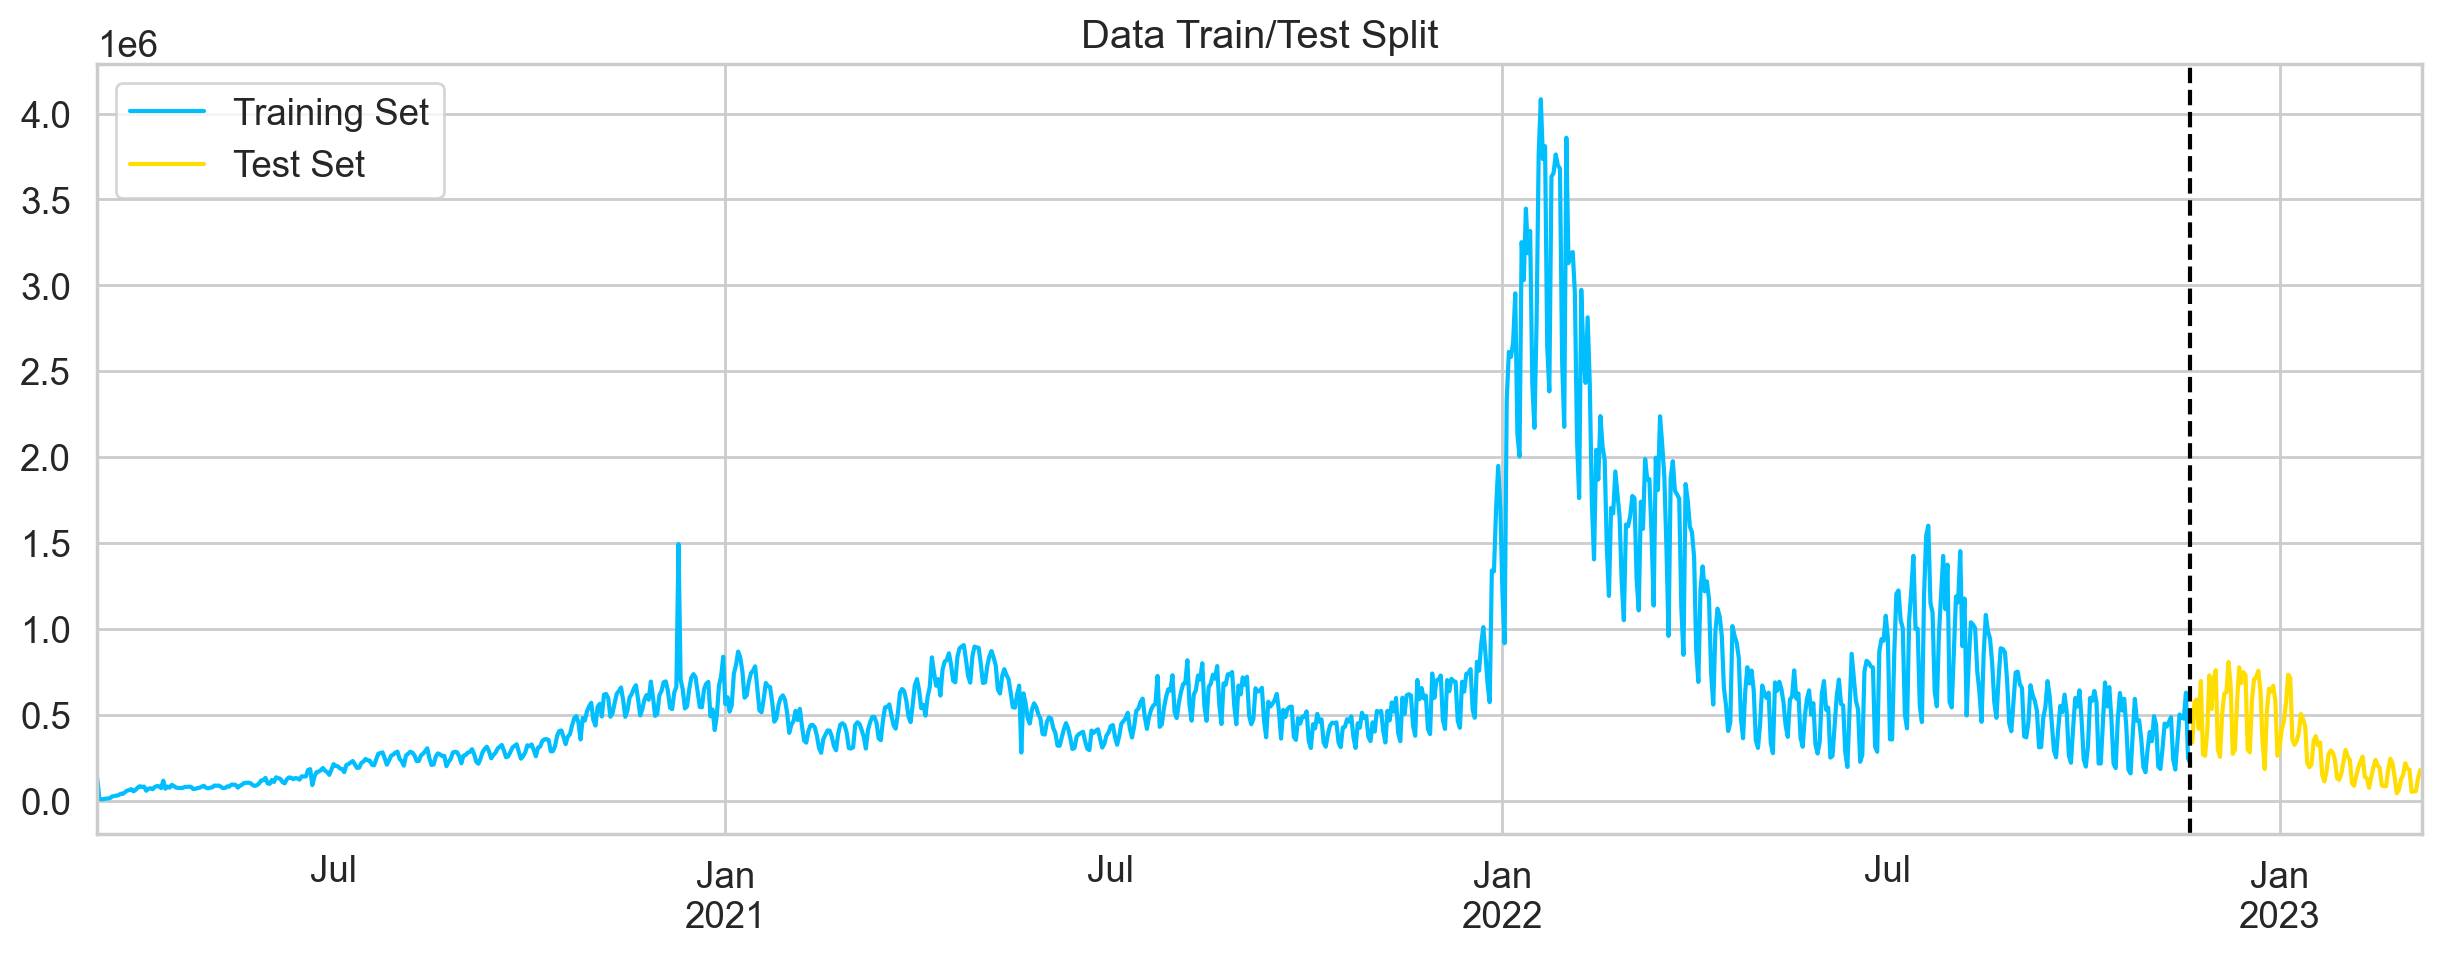

In [108]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_data.plot(ax=ax, label='Test Set')
ax.axvline('2022-11-20', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [109]:
#Scaling : scale the data (values will be between 0 and 1)
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [110]:
### Creat Sequence

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [111]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
### Build the model : LSTM

In [116]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [120]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 100

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [123]:
# Creat instance

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=4
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 48.24314880371094 test loss: 1.07283353805542
Epoch 10 train loss: 22.60034942626953 test loss: 1.160510778427124
Epoch 20 train loss: 22.433345794677734 test loss: 1.0433826446533203
Epoch 30 train loss: 22.3607177734375 test loss: 0.8215553164482117
Epoch 40 train loss: 22.37312126159668 test loss: 0.8609849214553833
Epoch 50 train loss: 22.39179229736328 test loss: 0.9436609745025635
Epoch 60 train loss: 22.254962921142578 test loss: 0.9897549748420715
Epoch 70 train loss: 22.53120994567871 test loss: 0.6782323718070984
Epoch 80 train loss: 22.42371940612793 test loss: 0.7686766982078552
Epoch 90 train loss: 22.444129943847656 test loss: 0.8813806772232056


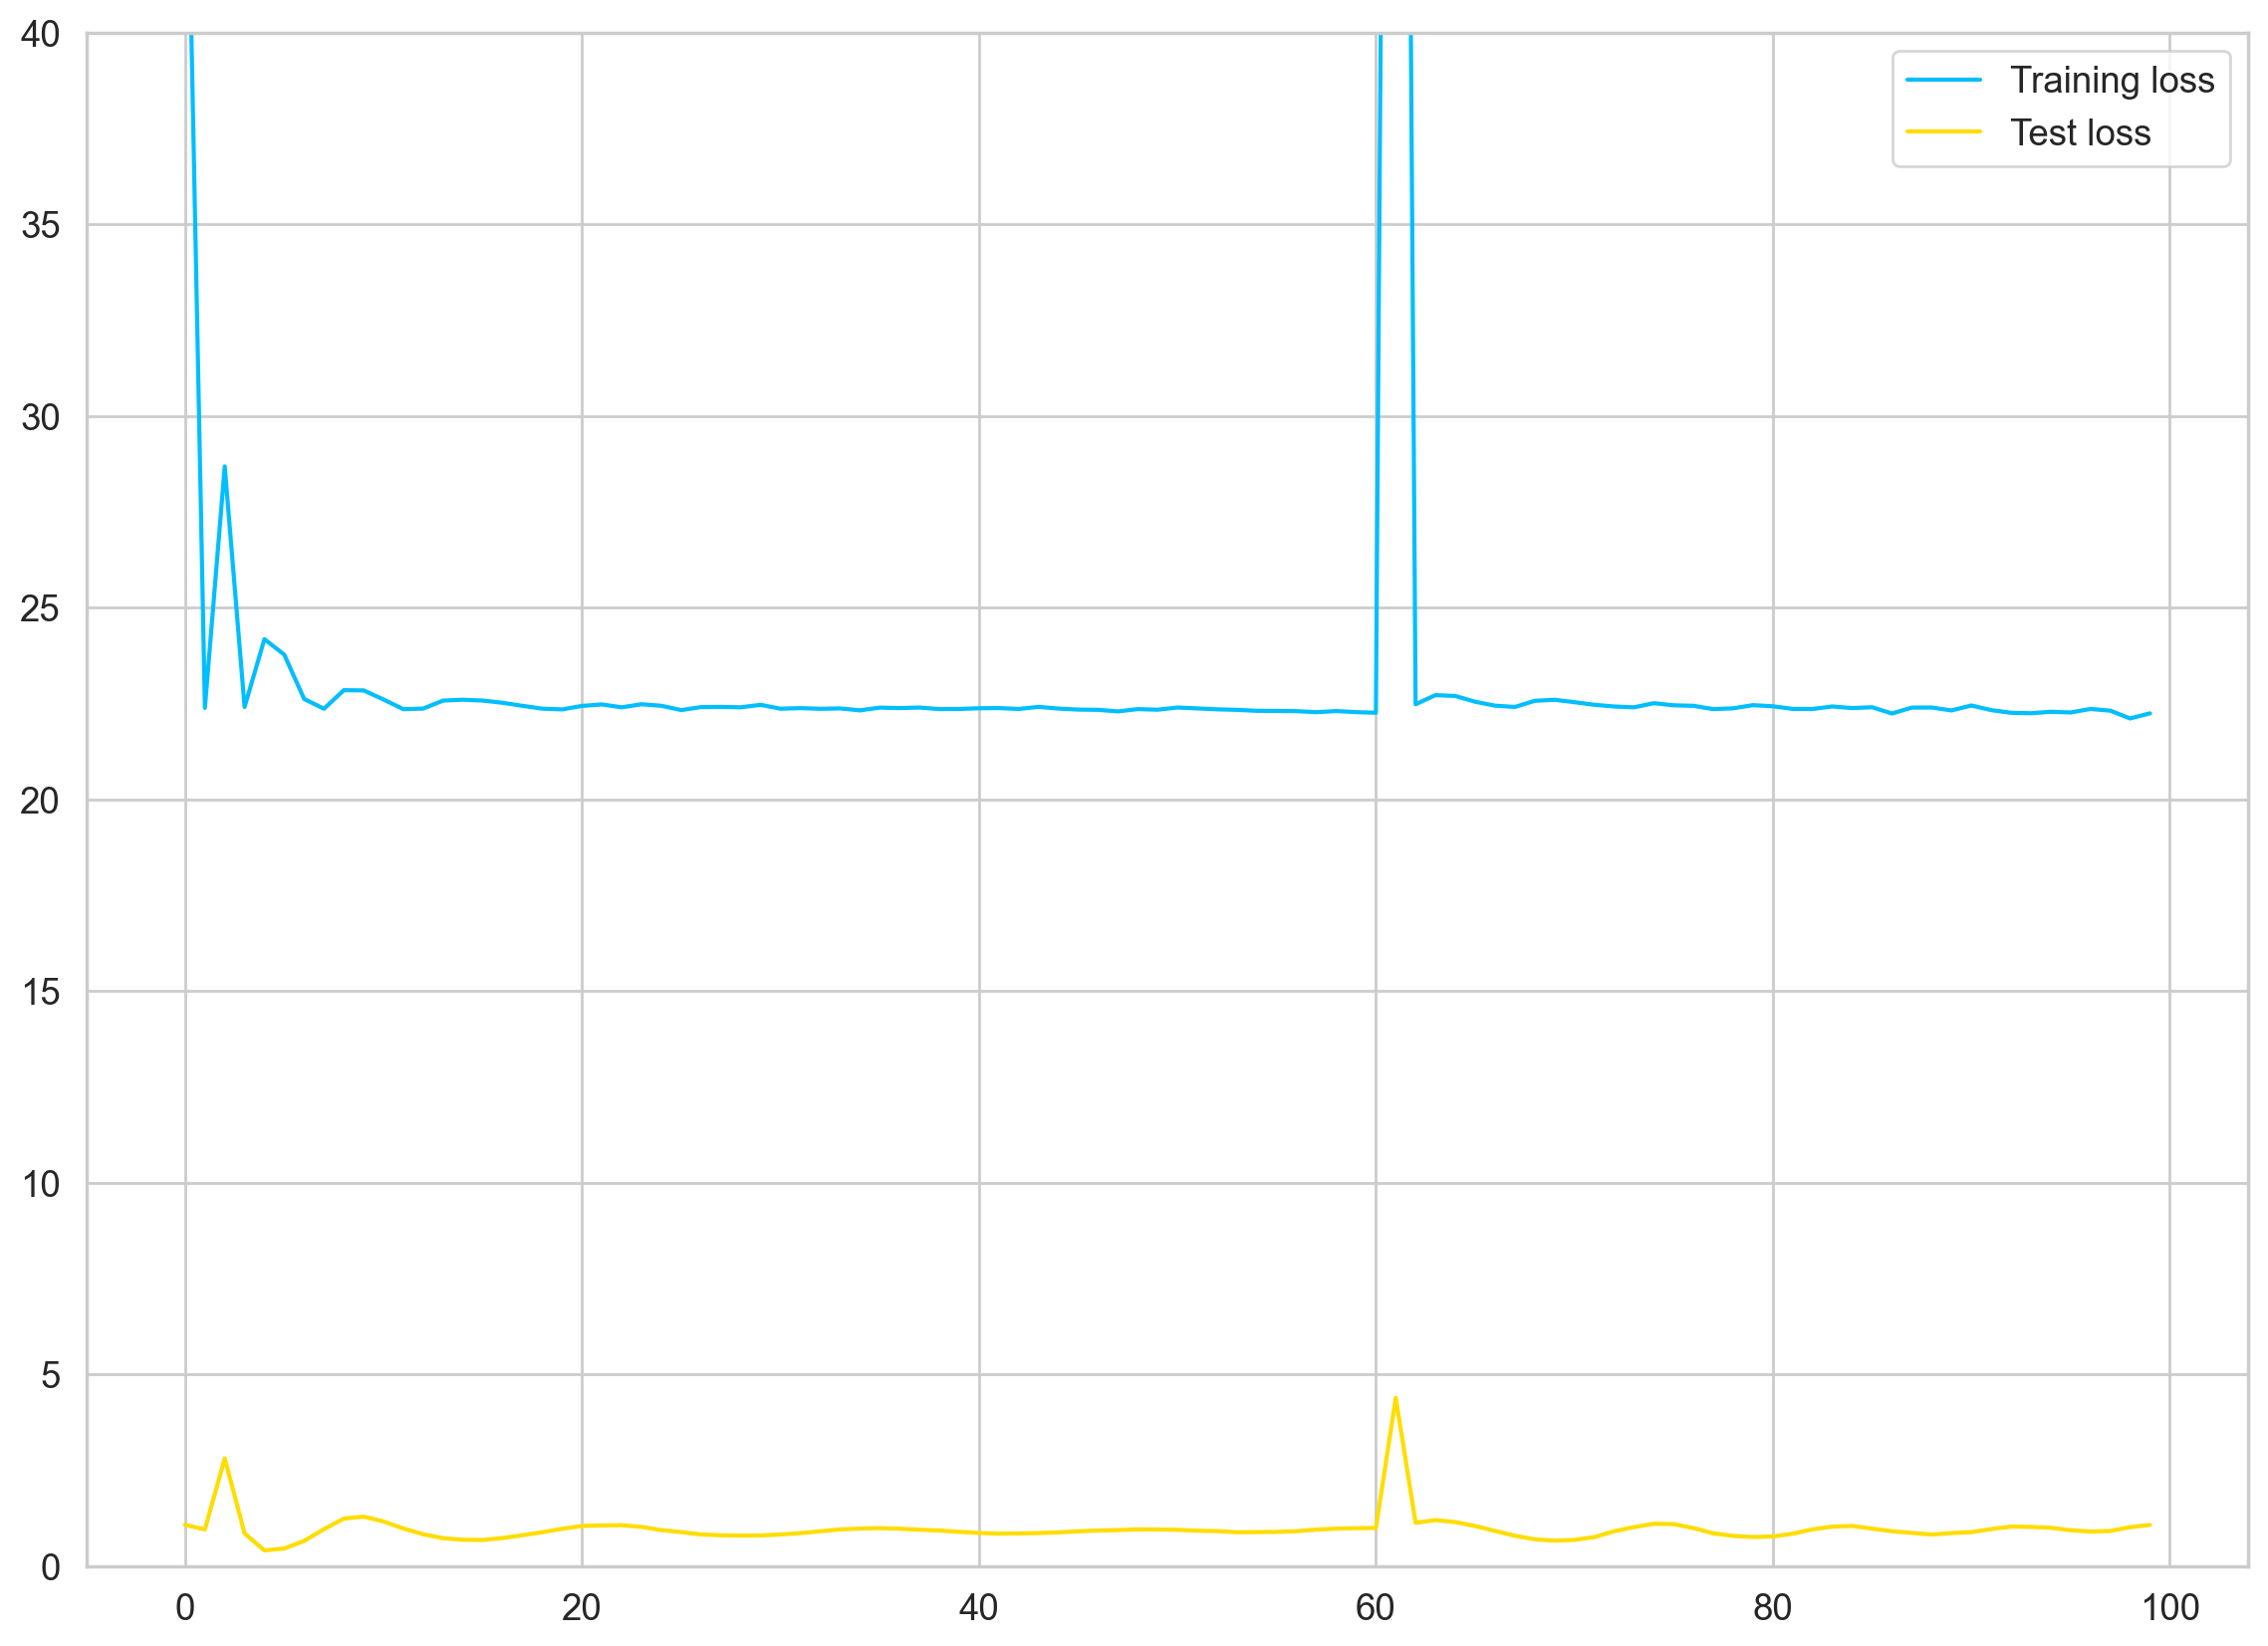

In [124]:
# Check Loss 
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 40))
plt.legend();    

In [ ]:
###Predicting daily cases

In [125]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [126]:
#reverse scaled values
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

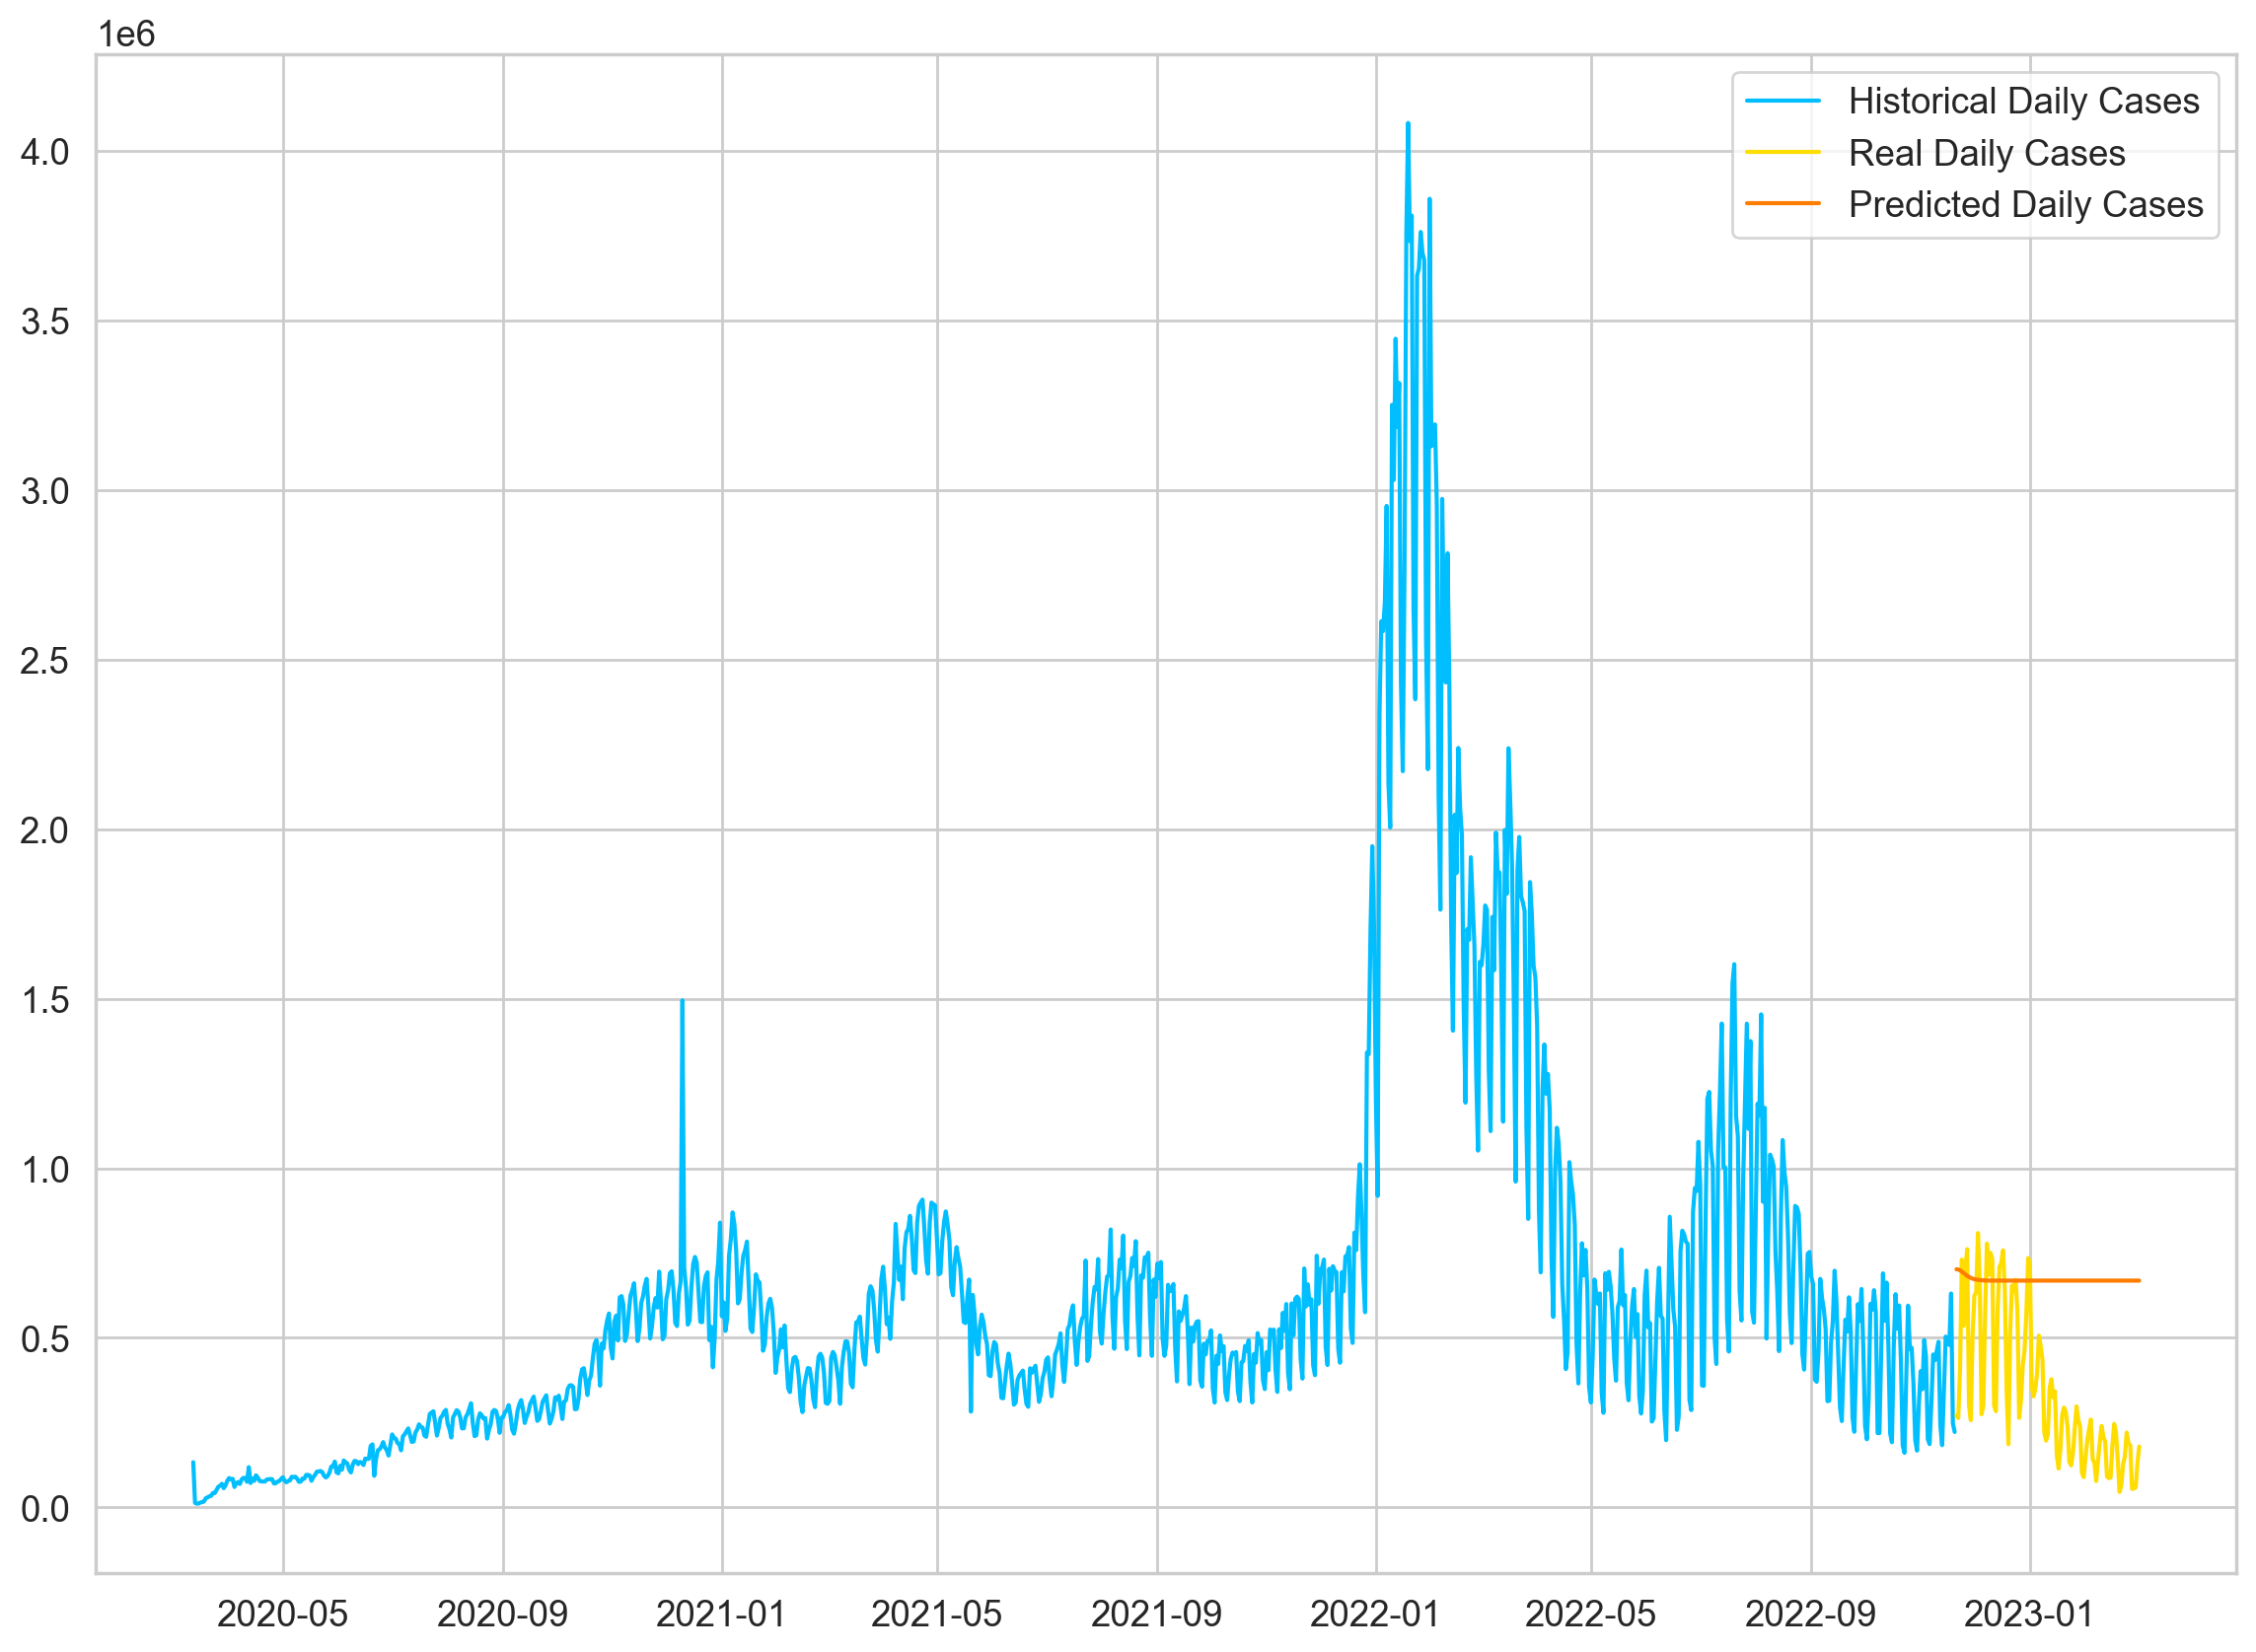

In [127]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [ ]:
###Use all data for training

In [128]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(1093, 1)

In [130]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=4
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 52.84225845336914
Epoch 10 train loss: 22.71600341796875
Epoch 20 train loss: 22.822219848632812
Epoch 30 train loss: 22.465396881103516
Epoch 40 train loss: 22.37303924560547
Epoch 50 train loss: 22.361629486083984
Epoch 60 train loss: 22.33528709411621
Epoch 70 train loss: 22.346153259277344
Epoch 80 train loss: 22.28413200378418
Epoch 90 train loss: 22.389318466186523


In [ ]:
###Predicting future cases
#predict the confirmed cases for 12 days into the future by using fully trained model

In [131]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [132]:
# reverse

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
     

In [134]:
#To predict the future, we need to extend the date index of our data frame

daily_cases.index[-1]

Timestamp('2023-03-09 00:00:00')

C:\Users\jongb\AppData\Local\Temp\ipykernel_32684\85051799.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


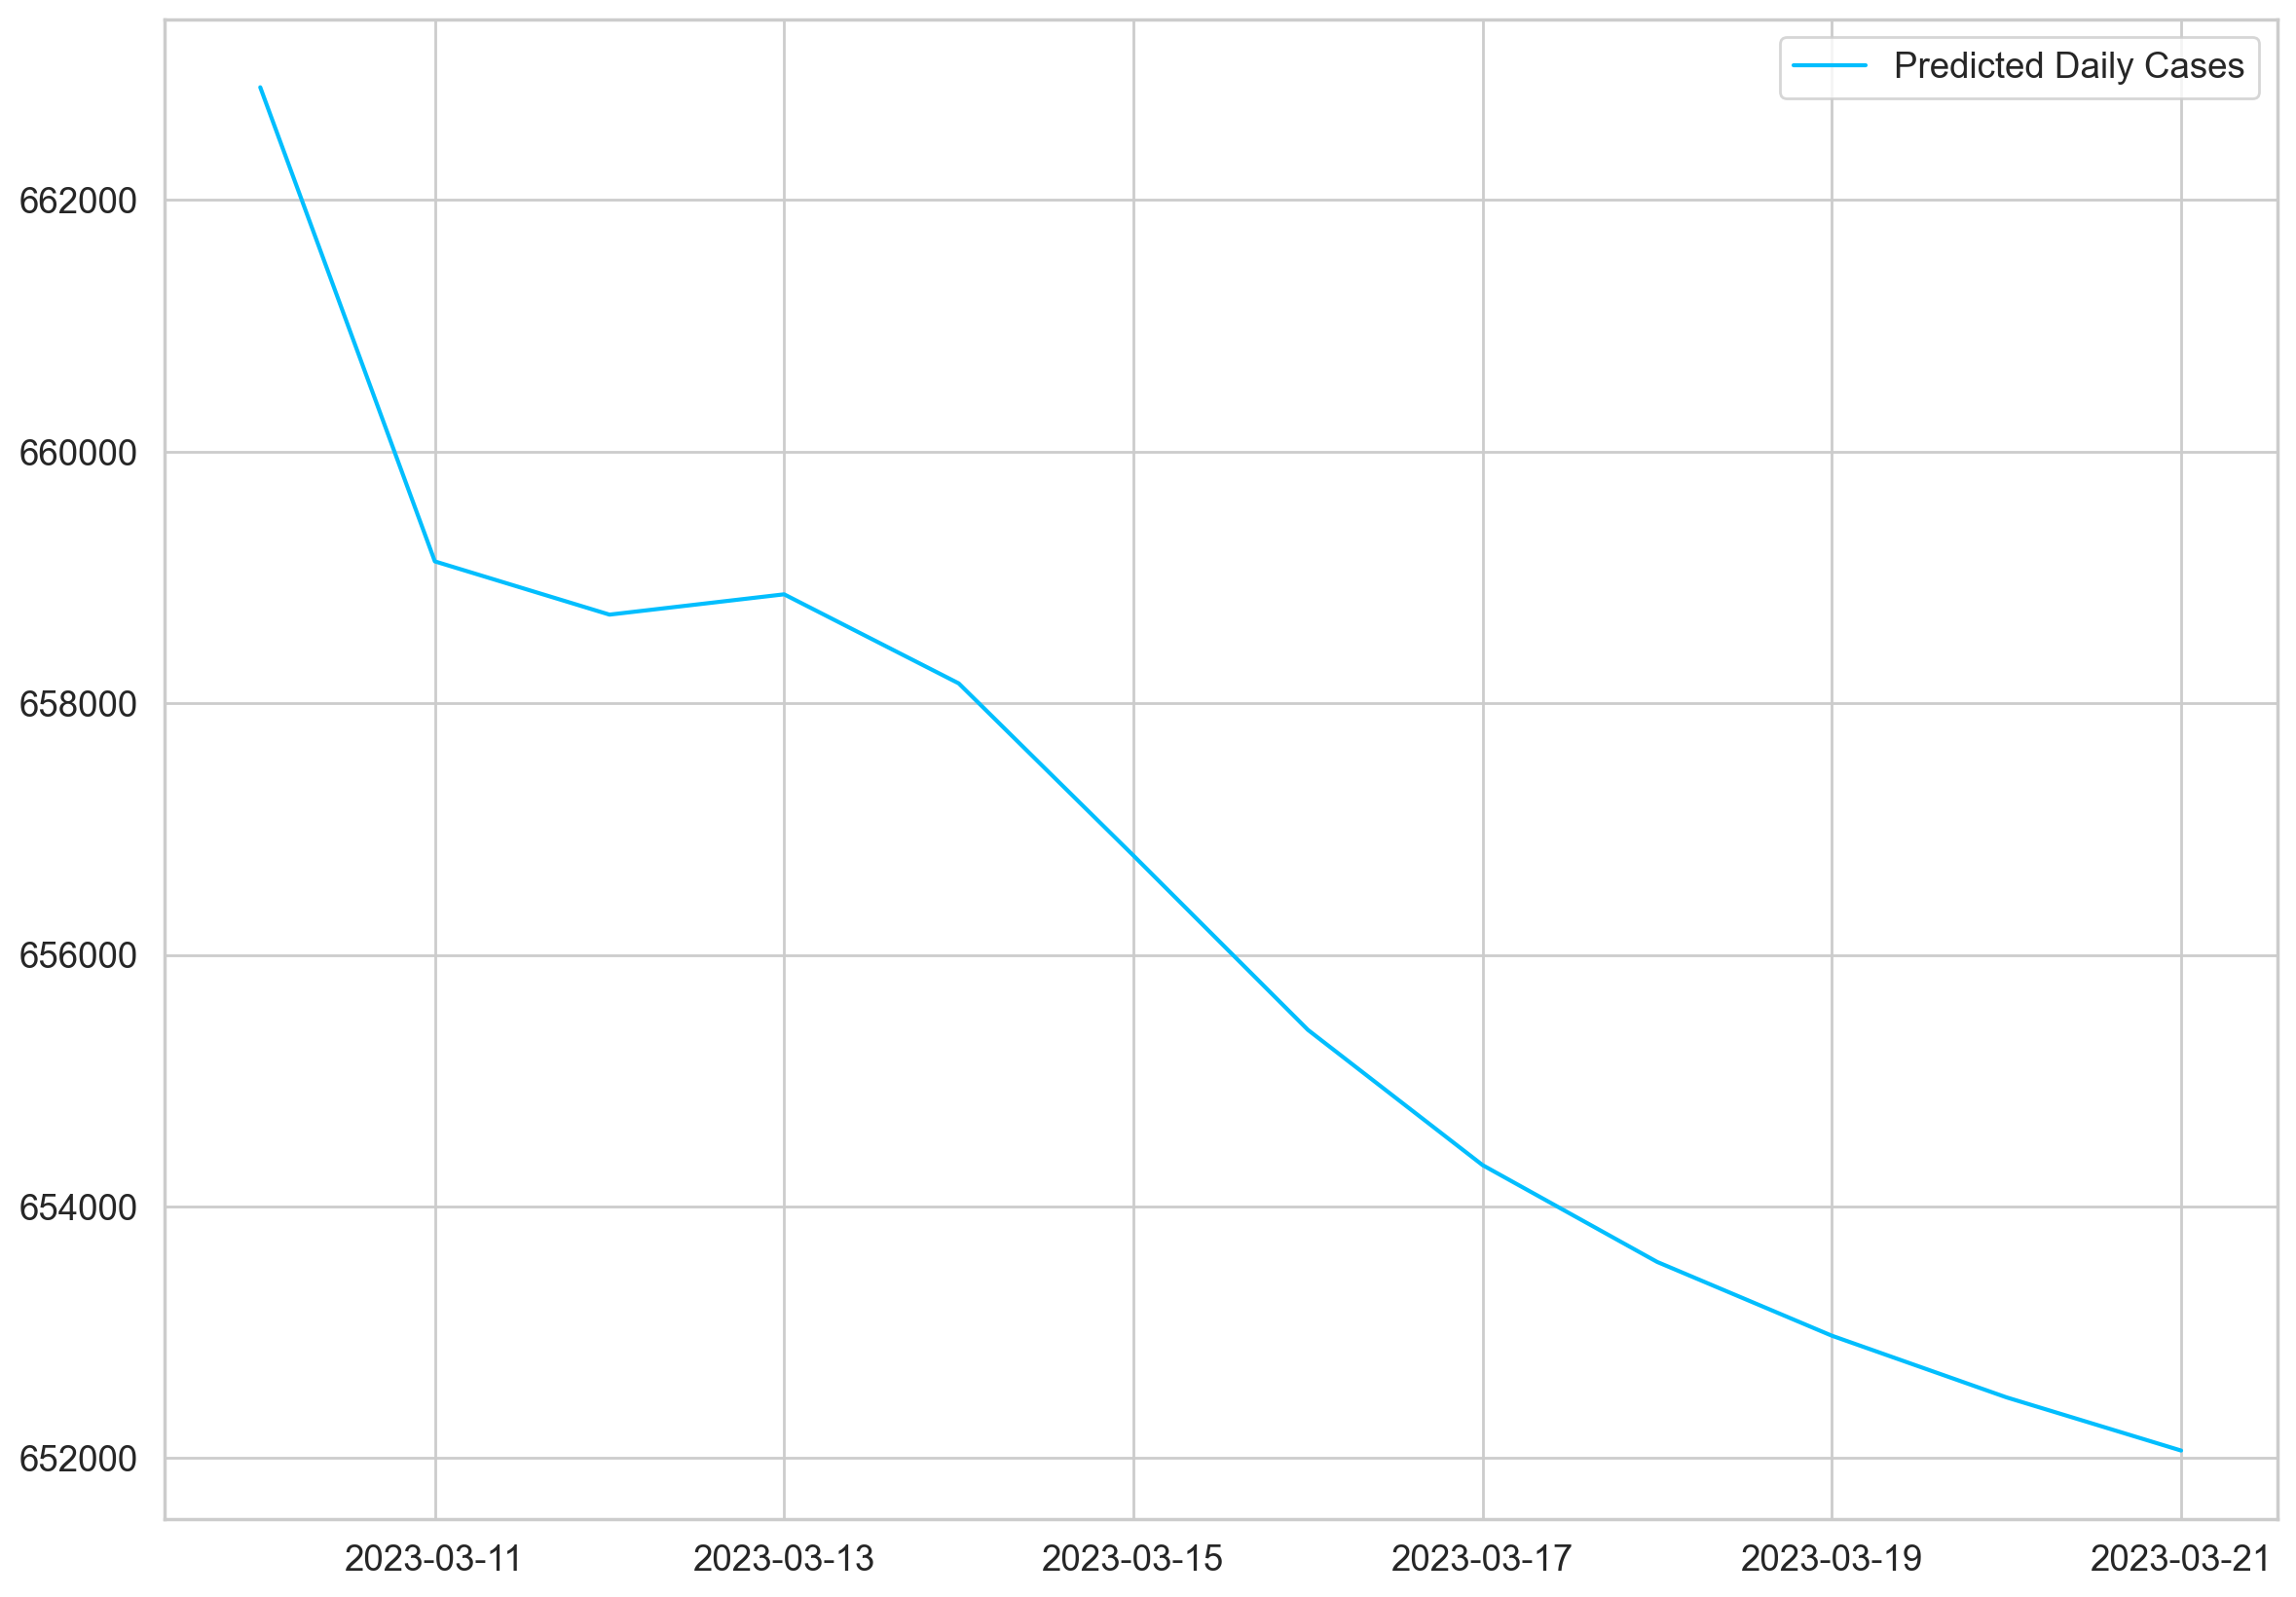

In [135]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();
     

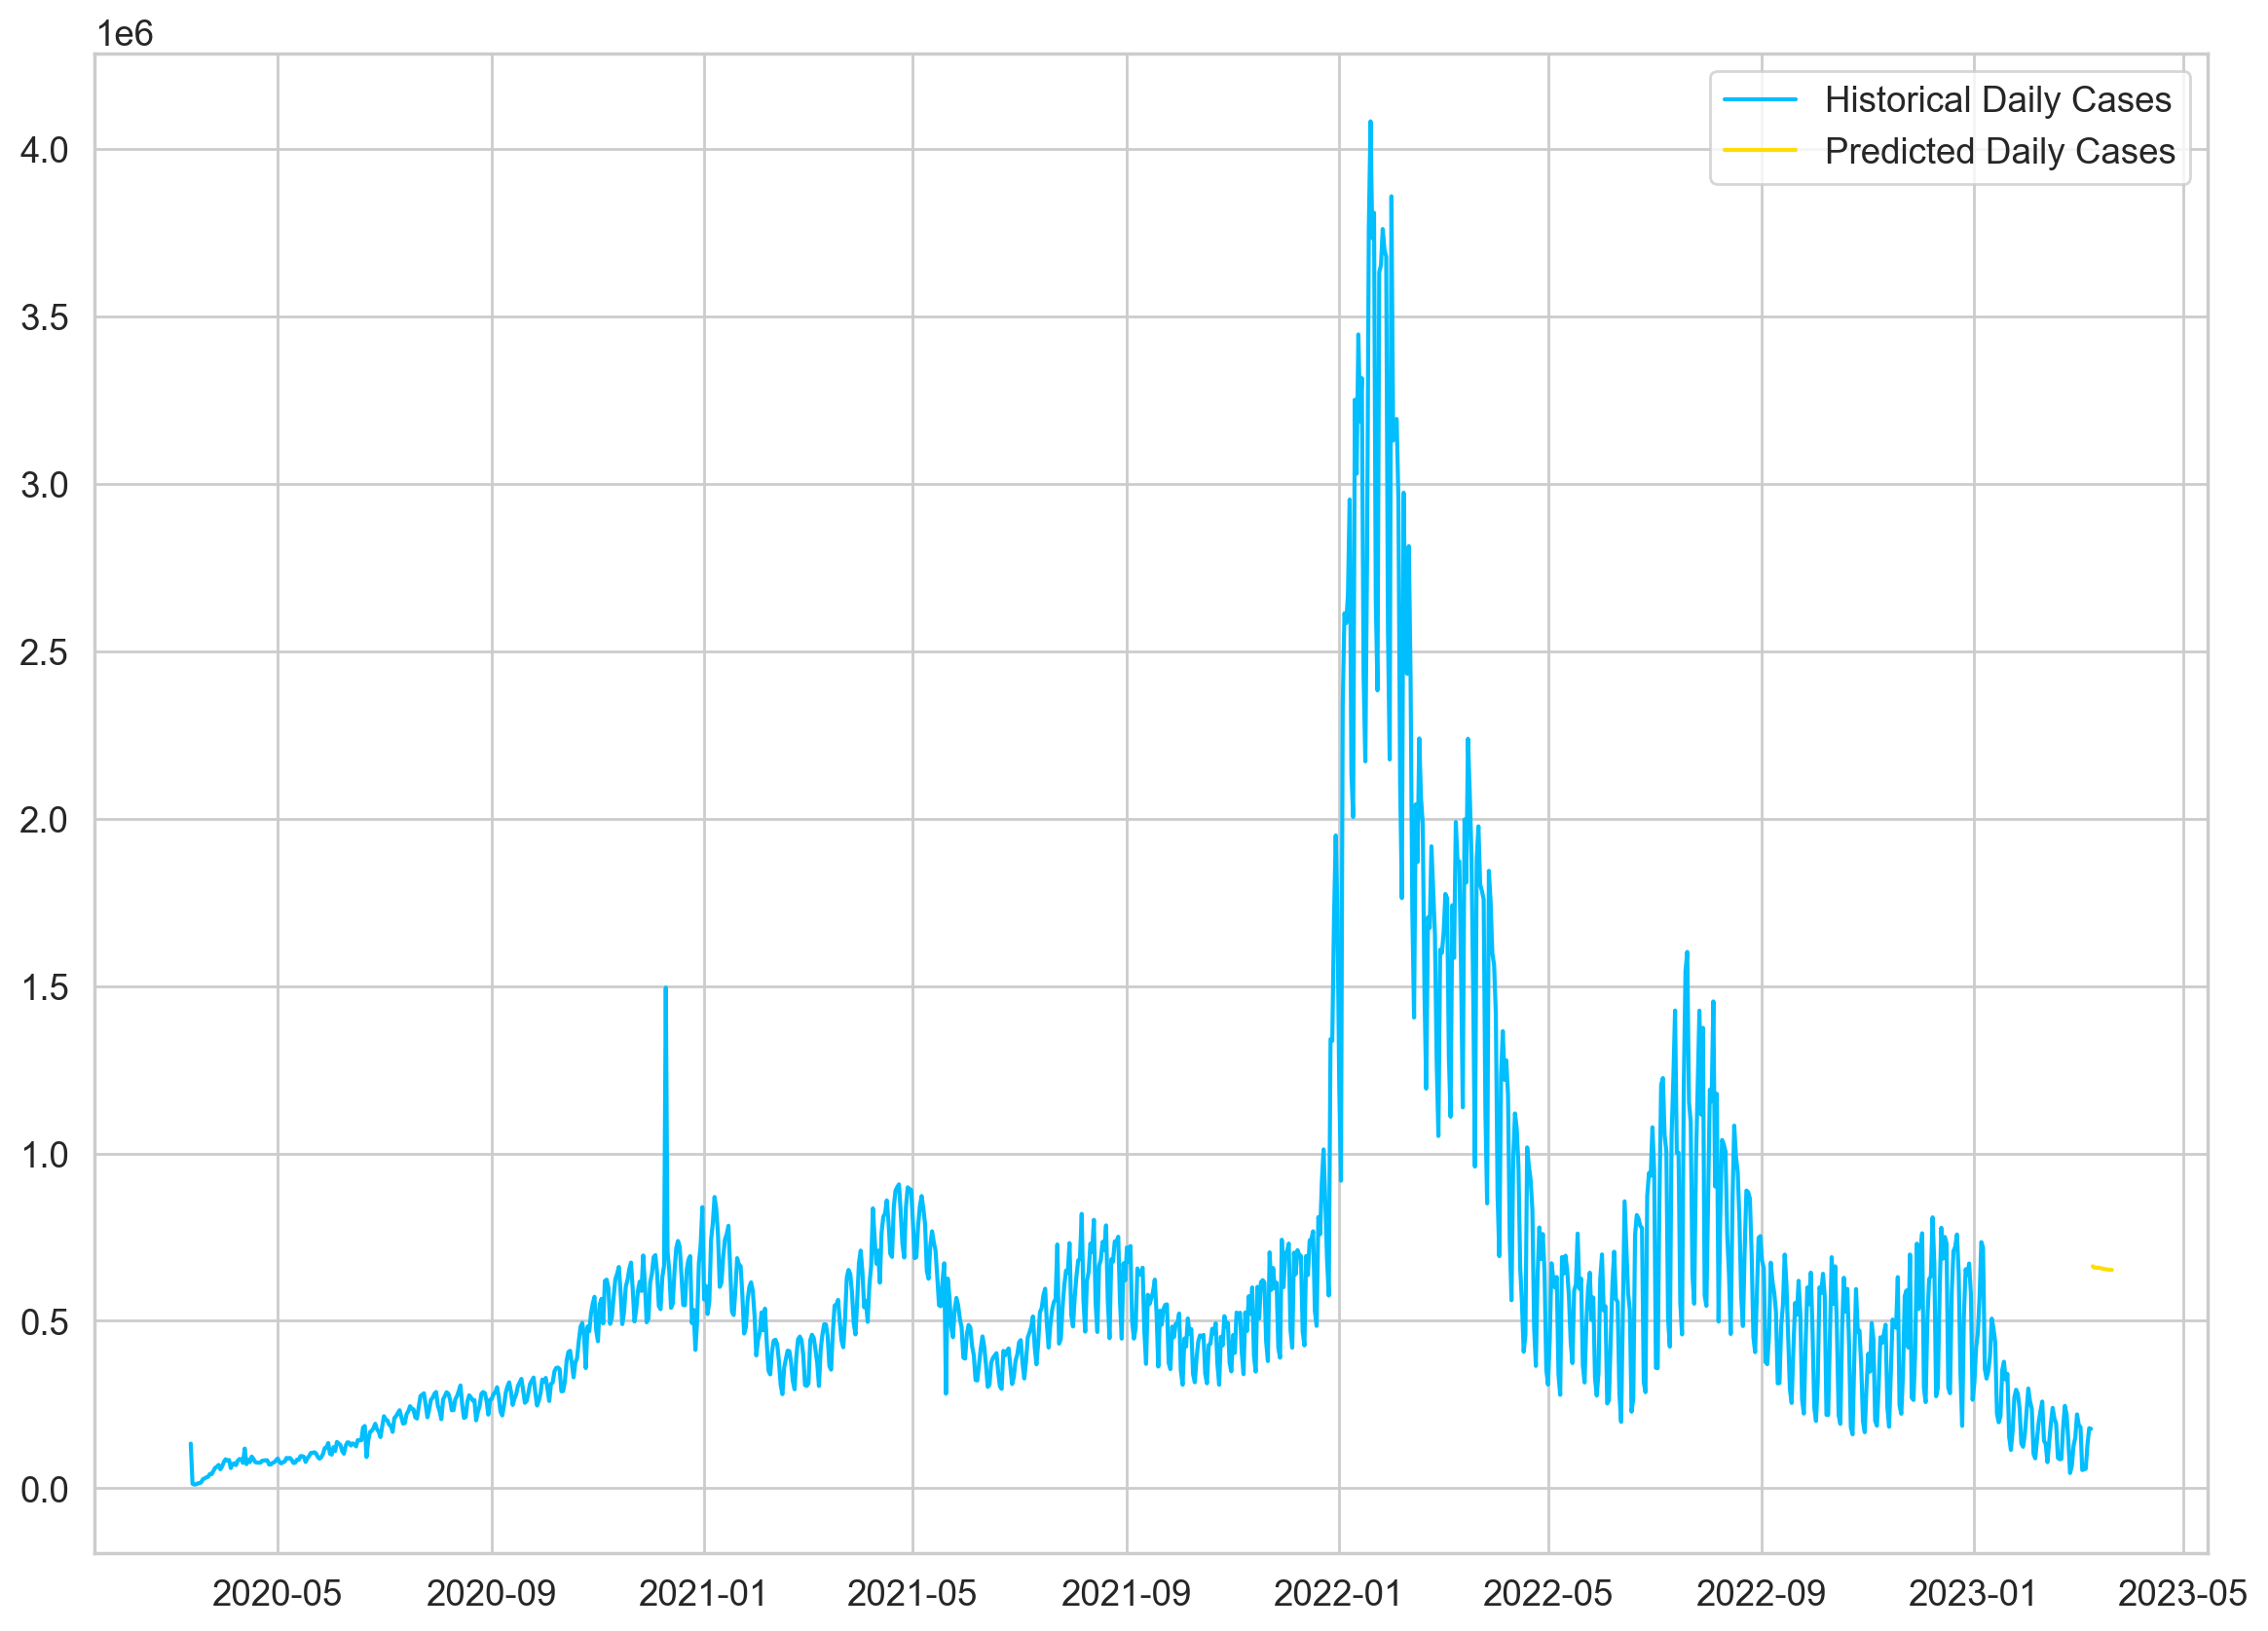

In [136]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
#Conclusion

#As you can see above the graph, it is likely to have downard trend. 
#Therefore, Covid19 is going to be stable and 'Overcomed desease'. 